---
title: "Why does SwiGLU work ?"
author: "Safouane Chergui"
date: "2026-01-14"
categories: [Python, NLP, Deep Learning]
---

The goal of this blog post is to explain why modern LLM architectures use `SwiGLU` as the activation function for the feed-forward part and have moved away from `ReLU`.

**Table of contents**<a id='toc0_'></a>    
- [Q1: Why do we need activation functions at all?](#toc1_)    
- [Q2: What's wrong with ReLU?](#toc2_)    
- [Q3: What is the Swish activation function?](#toc3_)       
- [Q4: What are Gated Linear Units (GLU)?](#toc4_)    
- [Q5: What is SwiGLU then?](#toc5_)    
- [Final note](#toc6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Q1: Why do we need activation functions at all?](#toc0_)

Consider this: a neural network is essentially a series of matrix multiplications. If we stack linear layers without any activation function:

$$y = W_3(W_2(W_1 x))$$

This simplifies to:

$$y = (W_3 W_2 W_1) x = W_{combined} x$$

No matter how many layers you stack, it's still just a linear transformation. The network can only learn linear relationships.

Activation functions introduce **non-linearity**, allowing the network to approximate complex, non-linear functions. This is the foundation of deep learning's expressive power.

Now, if you have a hard time mentally visualizing the impact of applying activation functions, I highly advise you to watch [the section 3 of this video](https://youtu.be/5_qrxVq1kvc?list=PL80I41oVxglKcAHllsU0txr3OuTTaWX2v&t=1693) from Alfredo Canziani's Deep Learning course. It will help you build a great intuition!

# <a id='toc2_'></a>[Q2: What's wrong with ReLU?](#toc0_)

`ReLU` literally revolutionized deep learning:

$$\text{ReLU}(x) = \max(0, x)$$

It's simple, fast, and solves the vanishing gradient problem that is a problem with functions like `sigmoid` or `tanh`. 

While people usually list problems that might be encountered when `ReLU` is used like the *dying neuron problem*, these problems are either theoritical or can be well managed most of the time with techniques used in neural networks nowadays (batch normalization, adaptive learning weights, etc)

# <a id='toc3_'></a>[Q3: What is the Swish activation function?](#toc0_)

Now, before moving to SwiGLU, we'll look at an activation function **Swish** that is part of **SwiGLU** 

$$\text{Swish}(x) = x \cdot \sigma(x) = \frac{x}{1 + e^{-x}}$$

Swish is a 'self-gated' activation function: the input $x$ is multiplied by its own sigmoid $\sigma(x)$, which acts as a **gate** that controls how much of the input passes through.

Looking at how the gate behaves:
- When $x$ is very negative: $\sigma(x) \approx 0$, so the gate is **closed** (suppresses the output)
- When $x$ is very positive: $\sigma(x) \approx 1$, so the gate is **fully open** (passes the input through almost unchanged)

Despite the bit more complicated formula, `Swish` has a very similar behavior to `ReLU`.

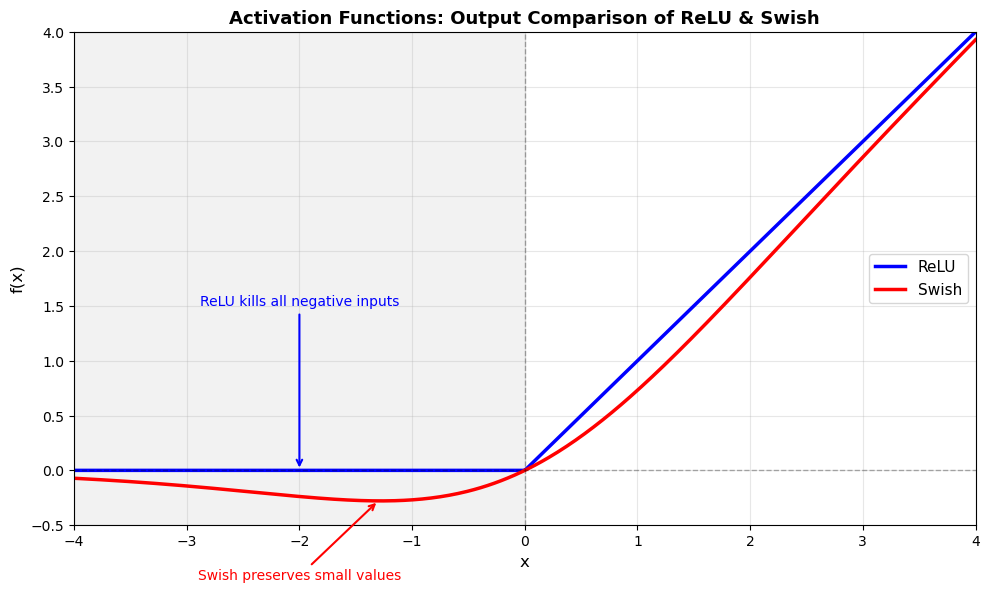

In [27]:
#| echo: false
x = np.linspace(-4, 4, 400)

fig, ax = plt.subplots(figsize=(10, 6))

# Function comparison - focus on negative region
ax.plot(x, np.maximum(0, x), 'b-', label='ReLU', linewidth=2.5)
ax.plot(x, swish(x), 'r-', label='Swish', linewidth=2.5)

# Highlight the negative region where they differ
ax.axvspan(-4, 0, alpha=0.1, color='gray')
ax.axhline(y=0, color='k', linestyle='--', alpha=0.3, linewidth=1)
ax.axvline(x=0, color='k', linestyle='--', alpha=0.3, linewidth=1)

# Annotate key difference
ax.annotate('ReLU kills all negative inputs', 
            xy=(-2, 0), xytext=(-2, 1.5),
            arrowprops=dict(arrowstyle='->', color='blue', lw=1.5),
            fontsize=10, color='blue', ha='center')
ax.annotate('Swish preserves small values', 
            xy=(-1.3, swish(np.array([-1.3]))[0]), xytext=(-2, -1),
            arrowprops=dict(arrowstyle='->', color='red', lw=1.5),
            fontsize=10, color='red', ha='center')

ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('f(x)', fontsize=12)
ax.set_title('Activation Functions: Output Comparison of ReLU & Swish', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim(-4, 4)
ax.set_ylim(-0.5, 4)

plt.tight_layout()
plt.show()

### <a id='toc3_1_1_'></a>[Is Swish better than ReLU?](#toc0_)

Empirically, `Swish` is found to work better than `ReLU` but like many things in deep learning, we don't know for sure why `Swish` works better, but here are the key differences:

**1. No hard gradient cutoff**

Looking at the plot above, the key difference is how they handle negative inputs:

- **ReLU**: Hard cutoff at zero
  - When $x < 0$: output = 0 & gradient = 0 (exactly)
  - This is the dying neuron problem (though as mentioned in Q2, it's often manageable with modern techniques like BatchNorm)

- **Swish**: Smooth, gradual approach to zero
  - For negative $x$: gradient approaches zero asymptotically but never exactly hits zero for finite values
  - Neurons can theoretically always receive updates (though updates may be negligible for very negative inputs)

**2. Smoothness**

`ReLU` has a discontinuity at $x = 0$ (derivative jumps from 0 to 1). `Swish` is infinitely differentiable everywhere, which means that the gradient landscape is smooth. Whether this smoothness contributes to the performance of `Swish` is not 100% clear but it's plausible that this helps with optimization

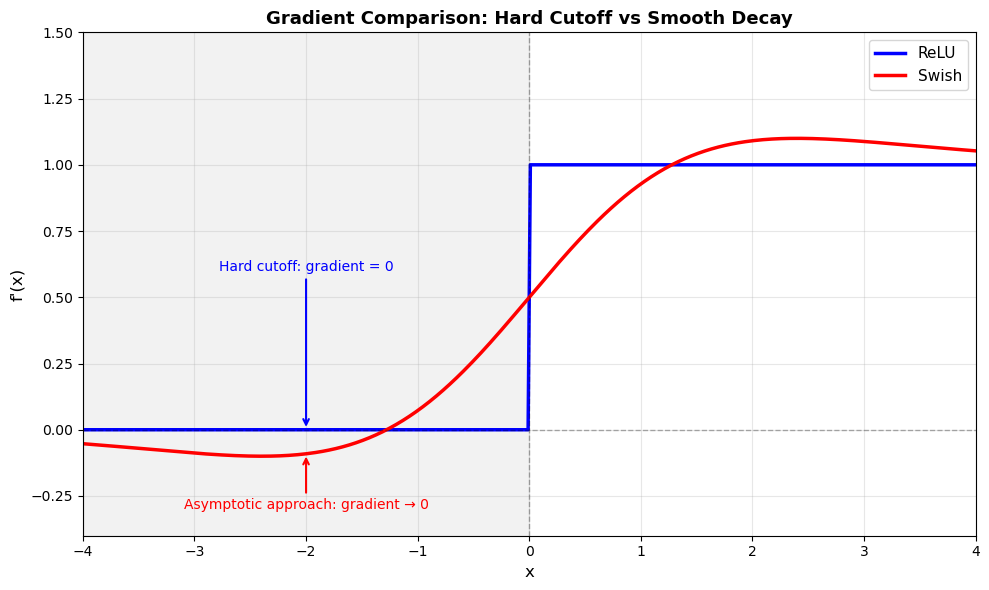

In [28]:
#| echo: false
x = np.linspace(-4, 4, 400)

fig, ax = plt.subplots(figsize=(10, 6))

# Compute derivatives
relu_grad = np.where(x > 0, 1, 0).astype(float)
relu_grad[np.abs(x) < 0.01] = np.nan  # Show discontinuity clearly

# Swish derivative: f'(x) = f(x) + σ(x)(1 - f(x))
swish_vals = swish(x)
sigmoid_vals = sigmoid(x)
swish_grad = swish_vals + sigmoid_vals * (1 - swish_vals)

ax.plot(x, relu_grad, 'b-', label="ReLU", linewidth=2.5)
ax.plot(x, swish_grad, 'r-', label="Swish", linewidth=2.5)

# Highlight the negative region
ax.axvspan(-4, 0, alpha=0.1, color='gray')
ax.axhline(y=0, color='k', linestyle='--', alpha=0.3, linewidth=1)
ax.axvline(x=0, color='k', linestyle='--', alpha=0.3, linewidth=1)

# Annotate the key insight
ax.annotate('Hard cutoff: gradient = 0', 
            xy=(-2, 0), xytext=(-2, 0.6),
            arrowprops=dict(arrowstyle='->', color='blue', lw=1.5),
            fontsize=10, color='blue', ha='center')
ax.annotate('Asymptotic approach: gradient → 0', 
            xy=(-2, swish_grad[np.argmin(np.abs(x + 2))]), xytext=(-2, -0.3),
            arrowprops=dict(arrowstyle='->', color='red', lw=1.5),
            fontsize=10, color='red', ha='center')

ax.set_xlabel('x', fontsize=12)
ax.set_ylabel("f'(x)", fontsize=12)
ax.set_title('Gradient Comparison: Hard Cutoff vs Smooth Decay', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim(-4, 4)
ax.set_ylim(-0.4, 1.5)

plt.tight_layout()
plt.show()

# <a id='toc4_'></a>[Q4: What are Gated Linear Units (GLU)?](#toc0_)

Now, this is our last component before getting to `SwiGLU`. Let's talk about **GLU**.

$$\text{GLU}(x, W, V, b, c) = (xW + b) \odot \sigma(xV + c)$$

Where:
- $x$ is the input
- $W, V$ are weight matrices
- $b, c$ are bias vectors
- $\odot$ is element-wise multiplication
- $\sigma$ is the sigmoid function

The first thing that you should note is that `GLU` uses a gating mechanism and is somehow similar to `Swish` in that manner. The difference is that instead of applying the same transformation (identity) to all features and then gating with a fixed function (sigmoid), GLU uses two separate linear projections:

1. $xW + b$: this just takes the input & transforms it. It is usually called the *content path*
2. $\sigma(xV + c)$: this second part says how much of the content of each feature should pass through and for that, it's called the *gate path*

So, `GLU` can really be thought of as a generalization fo `Swish`

### <a id='toc4_1_1_'></a>[Why is multiplicative gating powerful?](#toc0_)

The element-wise multiplication $\odot$ allows *the gate* to select which element of *the content* to let pass through. The gate can completely suppress certain features (when $\sigma(xV + c) \approx 0$) while fully passing through others (when $\sigma(xV + c) \approx 1$).

### <a id='toc4_1_2_'></a>[Concrete example of gating](#toc0_)

let suppose we have a 4-dim vector $x$

$$x = [1.0, -0.5, 2.0, 0.3]$$

GLU applies 2 transformations to this same input:

1. A transformation to the content through the content path: $xW + b$. Let us say that it produces $[2.0, -1.5, 3.0, 0.5]$
2. A 2nd transformation that's supposed to play the role of the gate: $\sigma(xV + c)$. Let us say that it produces $[0.9, 0.1, 0.95, 0.05]$

The GLU output is their element-wise product:

$$\text{GLU output} = [2.0 \times 0.9, \;\; -1.5 \times 0.1, \;\; 3.0 \times 0.95, \;\; 0.5 \times 0.05]$$
$$= [1.8, \;\; -0.15, \;\; 2.85, \;\; 0.025]$$

This means that:
- **Feature 1**: Content is positive (2.0), gate is high (0.9) → passes through strongly (1.8)
- **Feature 2**: Content is negative (-1.5), gate is low (0.1) → blocked (-0.15)
- **Feature 3**: Content is positive (3.0), gate is very high (0.95) → fully passes (2.85)
- **Feature 4**: Content is small (0.5), gate is very low (0.05) → suppressed (0.025)

This allows the network to learn complex decision rules: "for inputs like $x$, amplify feature 1 and 3, but suppress features 2 and 4."

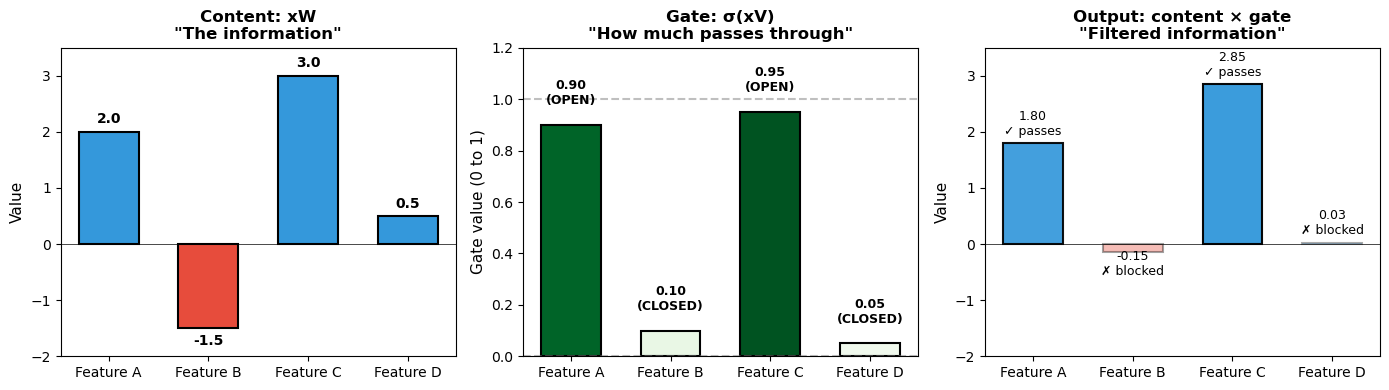

In [29]:
#| echo: false
# Simple 1D visualization: GLU as a "valve" controlling signal flow

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Example: 4 features going through GLU
features = ['Feature A', 'Feature B', 'Feature C', 'Feature D']
content = np.array([2.0, -1.5, 3.0, 0.5])  # What the content path produces
gate = np.array([0.9, 0.1, 0.95, 0.05])     # What the gate produces (after sigmoid)
output = content * gate

x_pos = np.arange(len(features))
width = 0.6

# Plot 1: Content (what information we have)
ax = axes[0]
colors_content = ['#3498db' if c >= 0 else '#e74c3c' for c in content]
bars = ax.bar(x_pos, content, width, color=colors_content, edgecolor='black', linewidth=1.5)
ax.set_xticks(x_pos)
ax.set_xticklabels(features, fontsize=10)
ax.set_ylabel('Value', fontsize=11)
ax.set_title('Content: xW\n"The information"', fontsize=12, fontweight='bold')
ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
ax.set_ylim(-2, 3.5)
for i, v in enumerate(content):
    ax.text(i, v + 0.15 if v >= 0 else v - 0.3, f'{v:.1f}', ha='center', fontsize=10, fontweight='bold')

# Plot 2: Gate (how open is the valve)
ax = axes[1]
colors_gate = plt.cm.Greens(gate)
bars = ax.bar(x_pos, gate, width, color=colors_gate, edgecolor='black', linewidth=1.5)
ax.set_xticks(x_pos)
ax.set_xticklabels(features, fontsize=10)
ax.set_ylabel('Gate value (0 to 1)', fontsize=11)
ax.set_title('Gate: σ(xV)\n"How much passes through"', fontsize=12, fontweight='bold')
ax.set_ylim(0, 1.2)
ax.axhline(y=1, color='gray', linestyle='--', alpha=0.5)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
for i, v in enumerate(gate):
    label = "OPEN" if v > 0.5 else "CLOSED"
    ax.text(i, v + 0.08, f'{v:.2f}\n({label})', ha='center', fontsize=9, fontweight='bold')

# Plot 3: Output (gated result)
ax = axes[2]
colors_output = ['#3498db' if c >= 0 else '#e74c3c' for c in output]
# Make bar transparency proportional to gate value for visual effect
for i, (pos, val, g) in enumerate(zip(x_pos, output, gate)):
    alpha = 0.3 + 0.7 * g  # More transparent when gate is low
    color = '#3498db' if val >= 0 else '#e74c3c'
    ax.bar(pos, val, width, color=color, alpha=alpha, edgecolor='black', linewidth=1.5)
ax.set_xticks(x_pos)
ax.set_xticklabels(features, fontsize=10)
ax.set_ylabel('Value', fontsize=11)
ax.set_title('Output: content × gate\n"Filtered information"', fontsize=12, fontweight='bold')
ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
ax.set_ylim(-2, 3.5)
for i, (v, g) in enumerate(zip(output, gate)):
    status = "✓ passes" if g > 0.5 else "✗ blocked"
    ax.text(i, v + 0.15 if v >= 0 else v - 0.4, f'{v:.2f}\n{status}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# <a id='toc5_'></a>[Q5: What is SwiGLU then?](#toc0_)

Now we have all the pieces. `SwiGLU` (Swish-Gated Linear Unit) simply combines Swish and GLU:

$$\text{SwiGLU}(x, W, V) = \text{Swish}(xW) \odot xV$$

That's it. Instead of using sigmoid for the gate (like in GLU), it uses Swish. That's why it's called **Swi**sh + **GLU**.

So what does each part of the formula do ? Well, it's exactly the same logic as GLU as what changes is just the gating function.

- $\text{Swish}(xW)$: The **gate** - decides how much of each feature passes through
- $xV$: The **content** - the actual information being transmitted
- $\odot$: Element-wise multiplication - applies the gate to the content

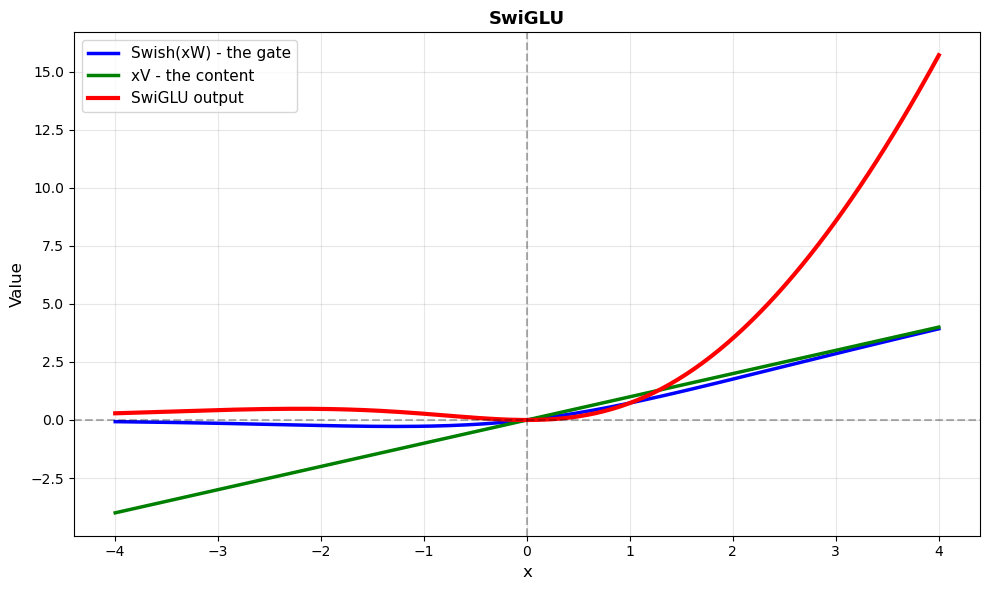

In [36]:
#| echo: false
# Simple visualization of SwiGLU components
x = np.linspace(-4, 4, 200)

# For visualization: assume xW = xV = x (identity projections)
xW = x
xV = x

swish_xW = swish(xW)
swiglu_output = swish_xW * xV

fig, ax = plt.subplots(figsize=(10, 6))

# The two paths and their combination
ax.plot(x, swish_xW, 'b-', label='Swish(xW) - the gate', linewidth=2.5)
ax.plot(x, xV, 'g-', label='xV - the content', linewidth=2.5)
ax.plot(x, swiglu_output, 'r-', label='SwiGLU output', linewidth=3)
ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax.axvline(x=0, color='k', linestyle='--', alpha=0.3)
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('Value', fontsize=12)
ax.set_title('SwiGLU', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### <a id='toc5_1_1_'></a>[Why does SwiGLU work so well?](#toc0_)

Empirically, SwiGLU outperforms other activation functions in LLMs (even though not sure about VLMs for now). But why? Here's the intuition:

**1. Multiplicative interactions create feature combinations**

This is the key insight. Consider what each architecture computes:

**Standard FFN** (ReLU/GELU): `output = activation(xW₁) @ W₂`

Each output dimension is a weighted sum of activated features. The activation is applied *element-wise*, this means that the features don't interact with each other inside the activation.

**SwiGLU FFN**: `output = (Swish(xW) ⊙ xV) @ W₂`

The element-wise multiplication $\odot$ creates **products between the two paths**. If we denote $g = \text{Swish}(xW)$ and $c = xV$, then output dimension $i$ before the final projection is $g_i \times c_i$.

Here's why this matters: both $g_i$ and $c_i$ are linear combinations of input features (before the Swish). Their product contains **cross-terms** like $x_j \times x_k$. The network can learn $W$ and $V$ such that certain input feature combinations are amplified or suppressed.

This is similar to why attention is powerful. Attention computes $\text{softmax}(QK^T)V$, where the $QK^T$ product captures interactions between query and key features. SwiGLU brings a similar multiplicative expressiveness to the FFN.

**2. Why not use sigmoid in the gate instead of Swish?**

GLU uses sigmoid: $\sigma(xW) \odot xV$. The problem with the `sigmoid` is that it saturate saturates. For large positive or negative inputs, $\sigma(x) \approx 1$ or $\sigma(x) \approx 0$, and the gradient $\frac{\partial \sigma}{\partial x} \approx 0$. The gate becomes "frozen."

Swish doesn't saturate for positive inputs, it grows approximately linearly (just like `ReLU`). This implies that:
- Gradients flow better through the gate path
- The gate can modulate rather than just switch on/off

**3. smoothness**

Another thing is that SwiGLU is infinitely differentiable & this smoothness likely helps optimization stability.

# <a id='toc6_'></a>[Final note](#toc0_)

SwiGLU's power comes from its **gating mechanism** & **multiplicative interactions**. By splitting the input into two paths and multiplying them, the network can learn which feature combinations matter (which is quite similar to how attention captures interactions through $QK^T$).

Combined with Swish's non-saturating gradients, this makes SwiGLU particularly effective for large models.